## Data Cleaning

##### Import necessary modules

In [23]:
from pyspark.sql import SparkSession
from utils.Constants import Constants
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

##### Configure the hadoop dir path

In [24]:
BASE_PATH = 'hdfs://localhost:8020/user/hadoop'
MERGED_PATH = f'{BASE_PATH}/merged'
CLEANED_PATH = f'{BASE_PATH}/cleaned'

##### Read the data that we have merged

In [25]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Read CSV from HDFS") \
    .getOrCreate()

# Path to the CSV file on HDFS
file_path = f'{MERGED_PATH}/combined_raw_data.csv'

# Read the CSV file into a DataFrame
df = spark.read.csv(file_path, header=True ,schema=Constants.RAW_DATA_SCHEMA )

df.printSchema()
df.show(5 , truncate=True)

root
 |-- Line#: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Water Content (m3/m3): float (nullable = true)
 |-- Solar Radiation (W/m2): float (nullable = true)
 |-- Rain (mm): float (nullable = true)
 |-- Temperature (Celcius): float (nullable = true)
 |-- RH (%): float (nullable = true)
 |-- Wind Speed (m/s): float (nullable = true)
 |-- Gust Speed (m/s): float (nullable = true)
 |-- Wind Direction (Degree): float (nullable = true)
 |-- Dew Point (Celcius): float (nullable = true)

+-----+--------+--------+---------------------+----------------------+---------+---------------------+------+----------------+----------------+-----------------------+-------------------+
|Line#|    Date|    Time|Water Content (m3/m3)|Solar Radiation (W/m2)|Rain (mm)|Temperature (Celcius)|RH (%)|Wind Speed (m/s)|Gust Speed (m/s)|Wind Direction (Degree)|Dew Point (Celcius)|
+-----+--------+--------+---------------------+----------------------+-------

##### Rename col.

In [26]:
df = df.withColumnRenamed("Date", "date") \
       .withColumnRenamed("time", "time") \
       .withColumnRenamed("Water Content (m3/m3)", "water_content") \
       .withColumnRenamed("Solar Radiation (W/m2)", "solar_radiation") \
       .withColumnRenamed("Rain (mm)", "rain") \
       .withColumnRenamed("Temperature (Celcius)", "temperature") \
       .withColumnRenamed("RH (%)", "rh") \
       .withColumnRenamed("Wind Speed (m/s)", "wind_speed") \
       .withColumnRenamed("Gust Speed (m/s)", "gust_speed") \
       .withColumnRenamed("Wind Direction (Degree)", "wind_direction") \
       .withColumnRenamed("Dew Point (Celcius)", "dew_point")
df.printSchema()

root
 |-- Line#: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- water_content: float (nullable = true)
 |-- solar_radiation: float (nullable = true)
 |-- rain: float (nullable = true)
 |-- temperature: float (nullable = true)
 |-- rh: float (nullable = true)
 |-- wind_speed: float (nullable = true)
 |-- gust_speed: float (nullable = true)
 |-- wind_direction: float (nullable = true)
 |-- dew_point: float (nullable = true)



##### Check Null Values with PySpark DataFrame

In [27]:
columns = df.columns

for col_name in columns:
    null_count = df.filter(df[col_name].isNull()).count()
    print(f"Column {col_name} has {null_count} NULL values.")


Column Line# has 0 NULL values.
Column date has 0 NULL values.
Column time has 0 NULL values.
Column water_content has 0 NULL values.
Column solar_radiation has 0 NULL values.
Column rain has 0 NULL values.
Column temperature has 0 NULL values.
Column rh has 0 NULL values.
Column wind_speed has 0 NULL values.
Column gust_speed has 0 NULL values.
Column wind_direction has 0 NULL values.
Column dew_point has 0 NULL values.


##### Check NaN Values With PySpark DataFrame

In [28]:
from pyspark.sql.functions import col as column, isnan ,count
columns = df.columns

for col_name in columns:
    null_count = df.filter(isnan(column(col_name))).count()
    print(f"Column {col_name} has {null_count} NaN values.")

Column Line# has 0 NaN values.
Column date has 0 NaN values.
Column time has 0 NaN values.
Column water_content has 3 NaN values.
Column solar_radiation has 3 NaN values.
Column rain has 3 NaN values.
Column temperature has 3 NaN values.
Column rh has 3 NaN values.
Column wind_speed has 3 NaN values.
Column gust_speed has 3 NaN values.
Column wind_direction has 3 NaN values.
Column dew_point has 3 NaN values.


#### Let Drop the row with nan value out from our dataframe

In [29]:
df = df.dropna()
columns = df.columns

for col_name in columns:
    null_count = df.filter(isnan(column(col_name))).count()
    print(f"Column {col_name} has {null_count} NaN values.")

Column Line# has 0 NaN values.
Column date has 0 NaN values.
Column time has 0 NaN values.
Column water_content has 0 NaN values.
Column solar_radiation has 0 NaN values.
Column rain has 0 NaN values.
Column temperature has 0 NaN values.
Column rh has 0 NaN values.
Column wind_speed has 0 NaN values.
Column gust_speed has 0 NaN values.
Column wind_direction has 0 NaN values.
Column dew_point has 0 NaN values.


##### Check the duplicate value in data set

In [30]:
duplicate_counts = df.groupBy(df.columns).agg(count("*").alias("count"))

duplicates = duplicate_counts.filter(column("count") > 1)

# Show duplicate rows
print("Duplicate rows:")
duplicates.show()

Duplicate rows:
+-----+----+----+-------------+---------------+----+-----------+---+----------+----------+--------------+---------+-----+
|Line#|date|time|water_content|solar_radiation|rain|temperature| rh|wind_speed|gust_speed|wind_direction|dew_point|count|
+-----+----+----+-------------+---------------+----+-----------+---+----------+----------+--------------+---------+-----+
+-----+----+----+-------------+---------------+----+-----------+---+----------+----------+--------------+---------+-----+



##### Change the format date from yy/MM/dd to dd-MM-yyyy

In [31]:
df = df.withColumn("date", F.date_format(F.to_date("Date", "yy/MM/dd"), "yyyy-MM-dd"))

df.show(5)

+-----+----------+--------+-------------+---------------+----+-----------+----+----------+----------+--------------+---------+
|Line#|      date|    time|water_content|solar_radiation|rain|temperature|  rh|wind_speed|gust_speed|wind_direction|dew_point|
+-----+----------+--------+-------------+---------------+----+-----------+----+----------+----------+--------------+---------+
|    1|2021-04-01|00:00:00|       0.2534|            1.0| 0.0|      28.12|80.6|       0.0|       0.3|         149.0|     24.5|
|    2|2021-04-01|00:05:00|       0.2532|            1.0| 0.0|      28.02|81.0|       0.0|       0.0|         215.0|    24.49|
|    3|2021-04-01|00:10:00|       0.2524|            1.0| 0.0|      28.07|81.0|       0.0|       1.3|         170.0|    24.53|
|    4|2021-04-01|00:15:00|       0.2524|            1.0| 0.0|       28.1|80.8|       0.0|       1.7|         166.0|    24.52|
|    5|2021-04-01|00:20:00|       0.2524|            1.0| 0.0|      28.07|80.8|       0.3|       2.7|         1

##### Drop Line# Column

In [32]:
df = df.drop("Line#")

In [33]:
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- water_content: float (nullable = true)
 |-- solar_radiation: float (nullable = true)
 |-- rain: float (nullable = true)
 |-- temperature: float (nullable = true)
 |-- rh: float (nullable = true)
 |-- wind_speed: float (nullable = true)
 |-- gust_speed: float (nullable = true)
 |-- wind_direction: float (nullable = true)
 |-- dew_point: float (nullable = true)



##### Creating a variable to store all the numerical columns into a list

In [34]:
numeric_columns = ["water_content", "solar_radiation", "temperature", "rh", "wind_speed", "gust_speed", "dew_point","wind_direction"]
numeric_columns

['water_content',
 'solar_radiation',
 'temperature',
 'rh',
 'wind_speed',
 'gust_speed',
 'dew_point',
 'wind_direction']

##### Convert to pandas dataframe work with plot

In [35]:
df = df.toPandas()

##### Check data null ft heatmap

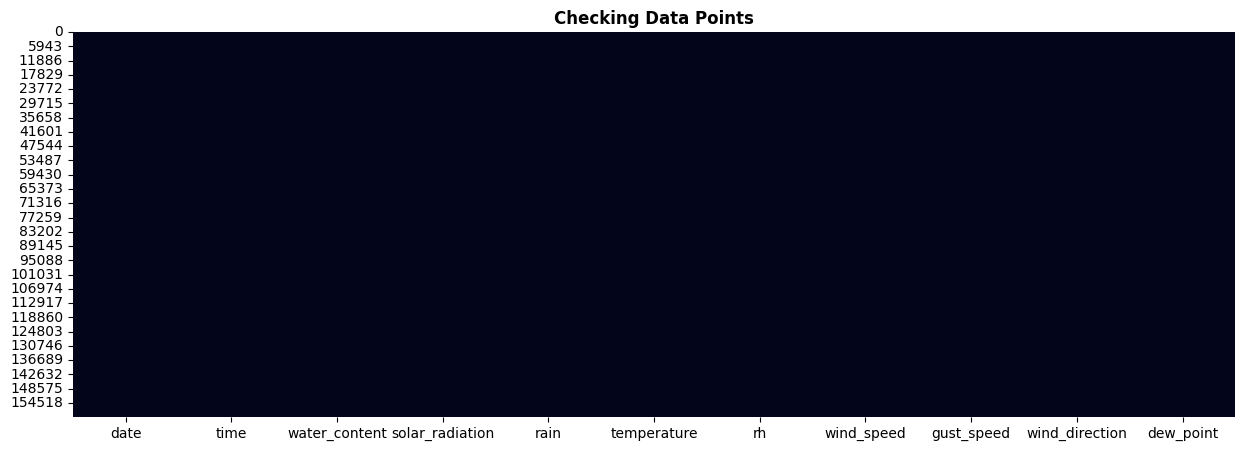

In [36]:
plt.figure(figsize=(15,5))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Checking Data Points", fontweight='bold')
plt.xticks(rotation='horizontal')
plt.show()

##### Plot as boxplot to see the outlier

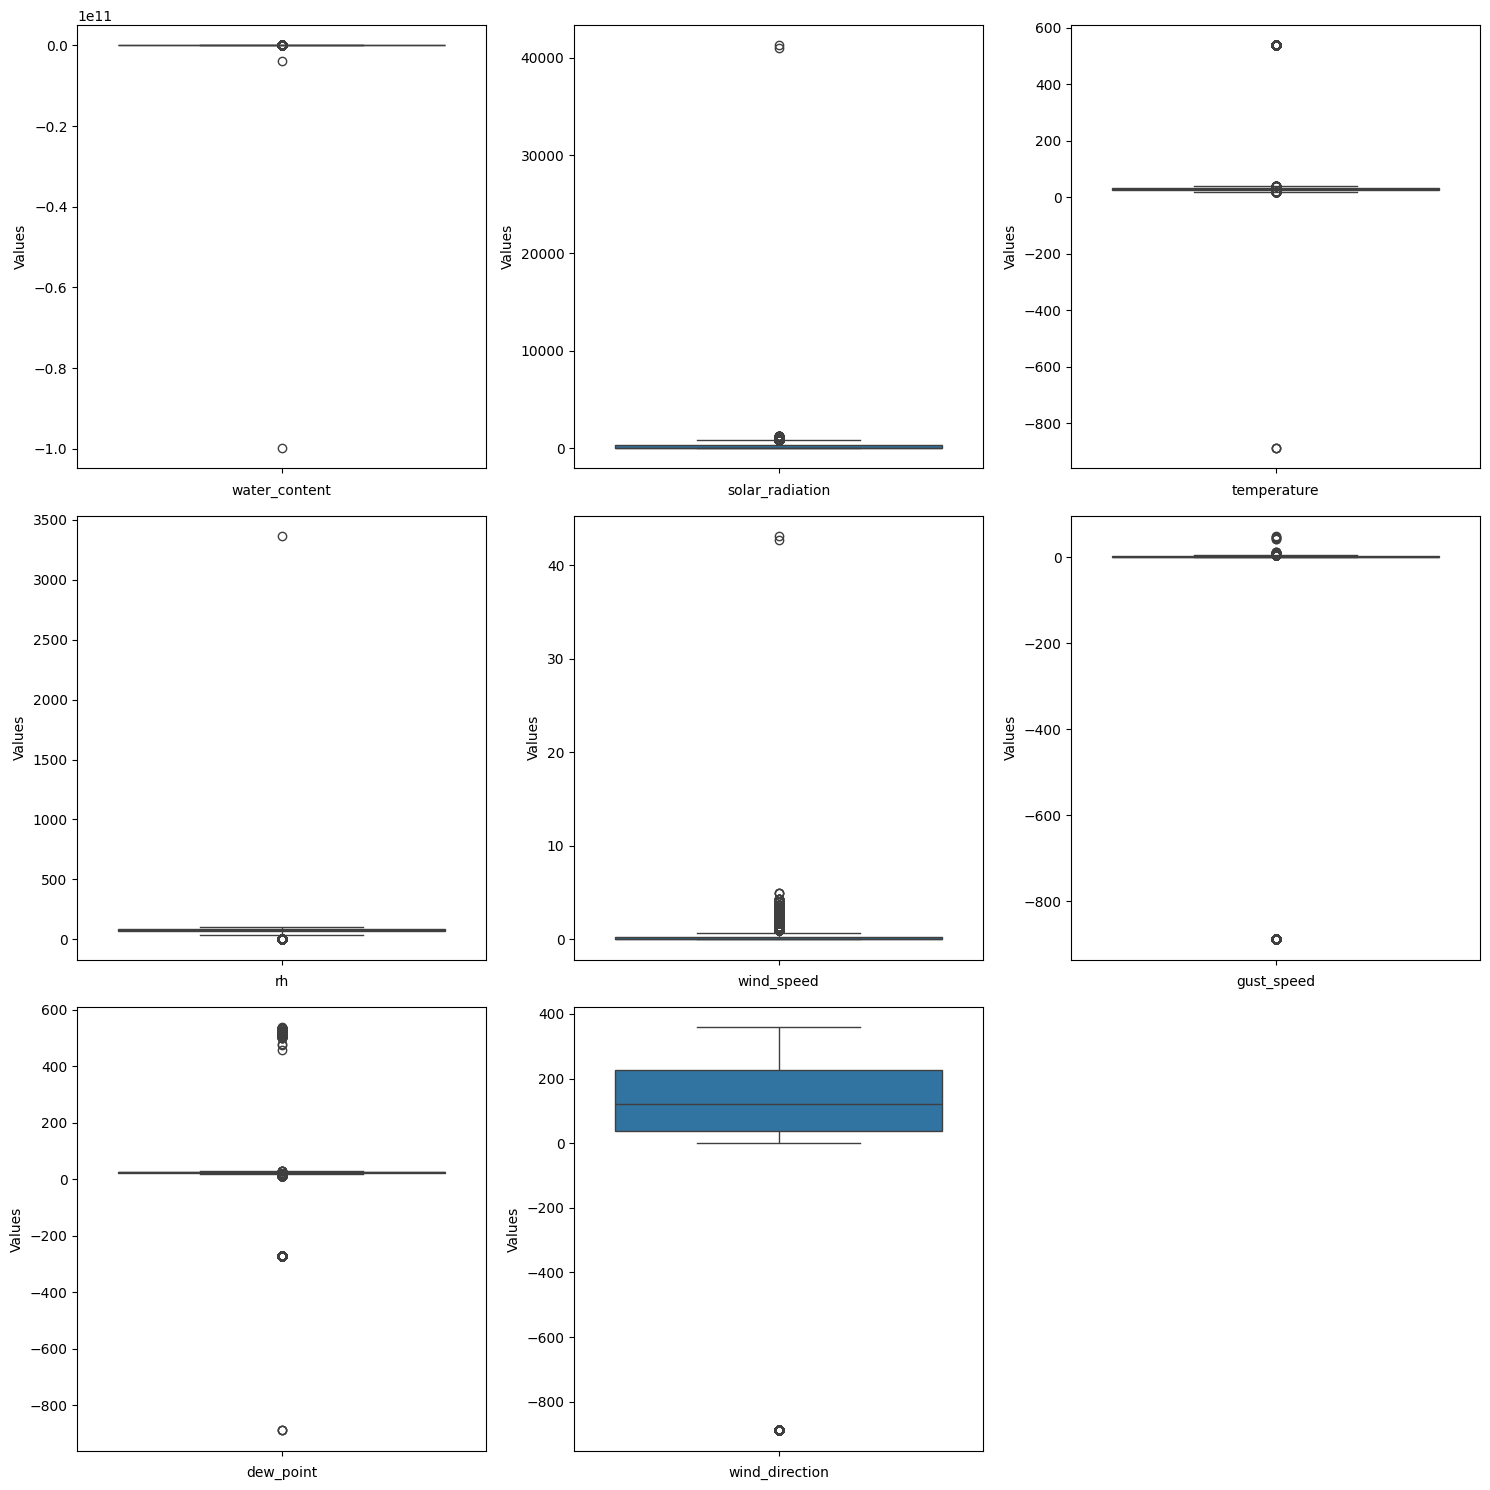

In [37]:
numeric_data = df[numeric_columns]

ncols = 3
nrows = int(np.ceil(len(numeric_columns) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 5))

axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(data=numeric_data[column], ax=axes[i])
    axes[i].set_ylabel("Values")
    axes[i].set_xlabel(column)

for i in range(len(numeric_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


##### Sort the entire dataframe asc

In [38]:
# df = df.sort_values(by=numeric_columns, ascending=True)
# df.head()

##### Function to deal with outlier

In [39]:
from scipy.stats import zscore

# Define numeric columns
numeric_columns = [
    "water_content", "solar_radiation", "temperature", "rh", 
    "wind_speed", "gust_speed", "dew_point", "wind_direction"
]

# Compute Z-scores for each numeric column
df[[f"{col}_zscore" for col in numeric_columns]] = df[numeric_columns].apply(zscore)

# Identify outliers
outlier_mask = (df[[f"{col}_zscore" for col in numeric_columns]] > 3.0) | \
               (df[[f"{col}_zscore" for col in numeric_columns]] < -3.0)

# Drop rows containing outliers
df_cleaned = df[~outlier_mask.any(axis=1)]

# Drop Z-score columns
df_cleaned.drop(columns=[f"{col}_zscore" for col in numeric_columns], inplace=True)


/tmp/ipykernel_59092/2729494655.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop(columns=[f"{col}_zscore" for col in numeric_columns], inplace=True)


##### Filter out the outiler from dataframe

154637


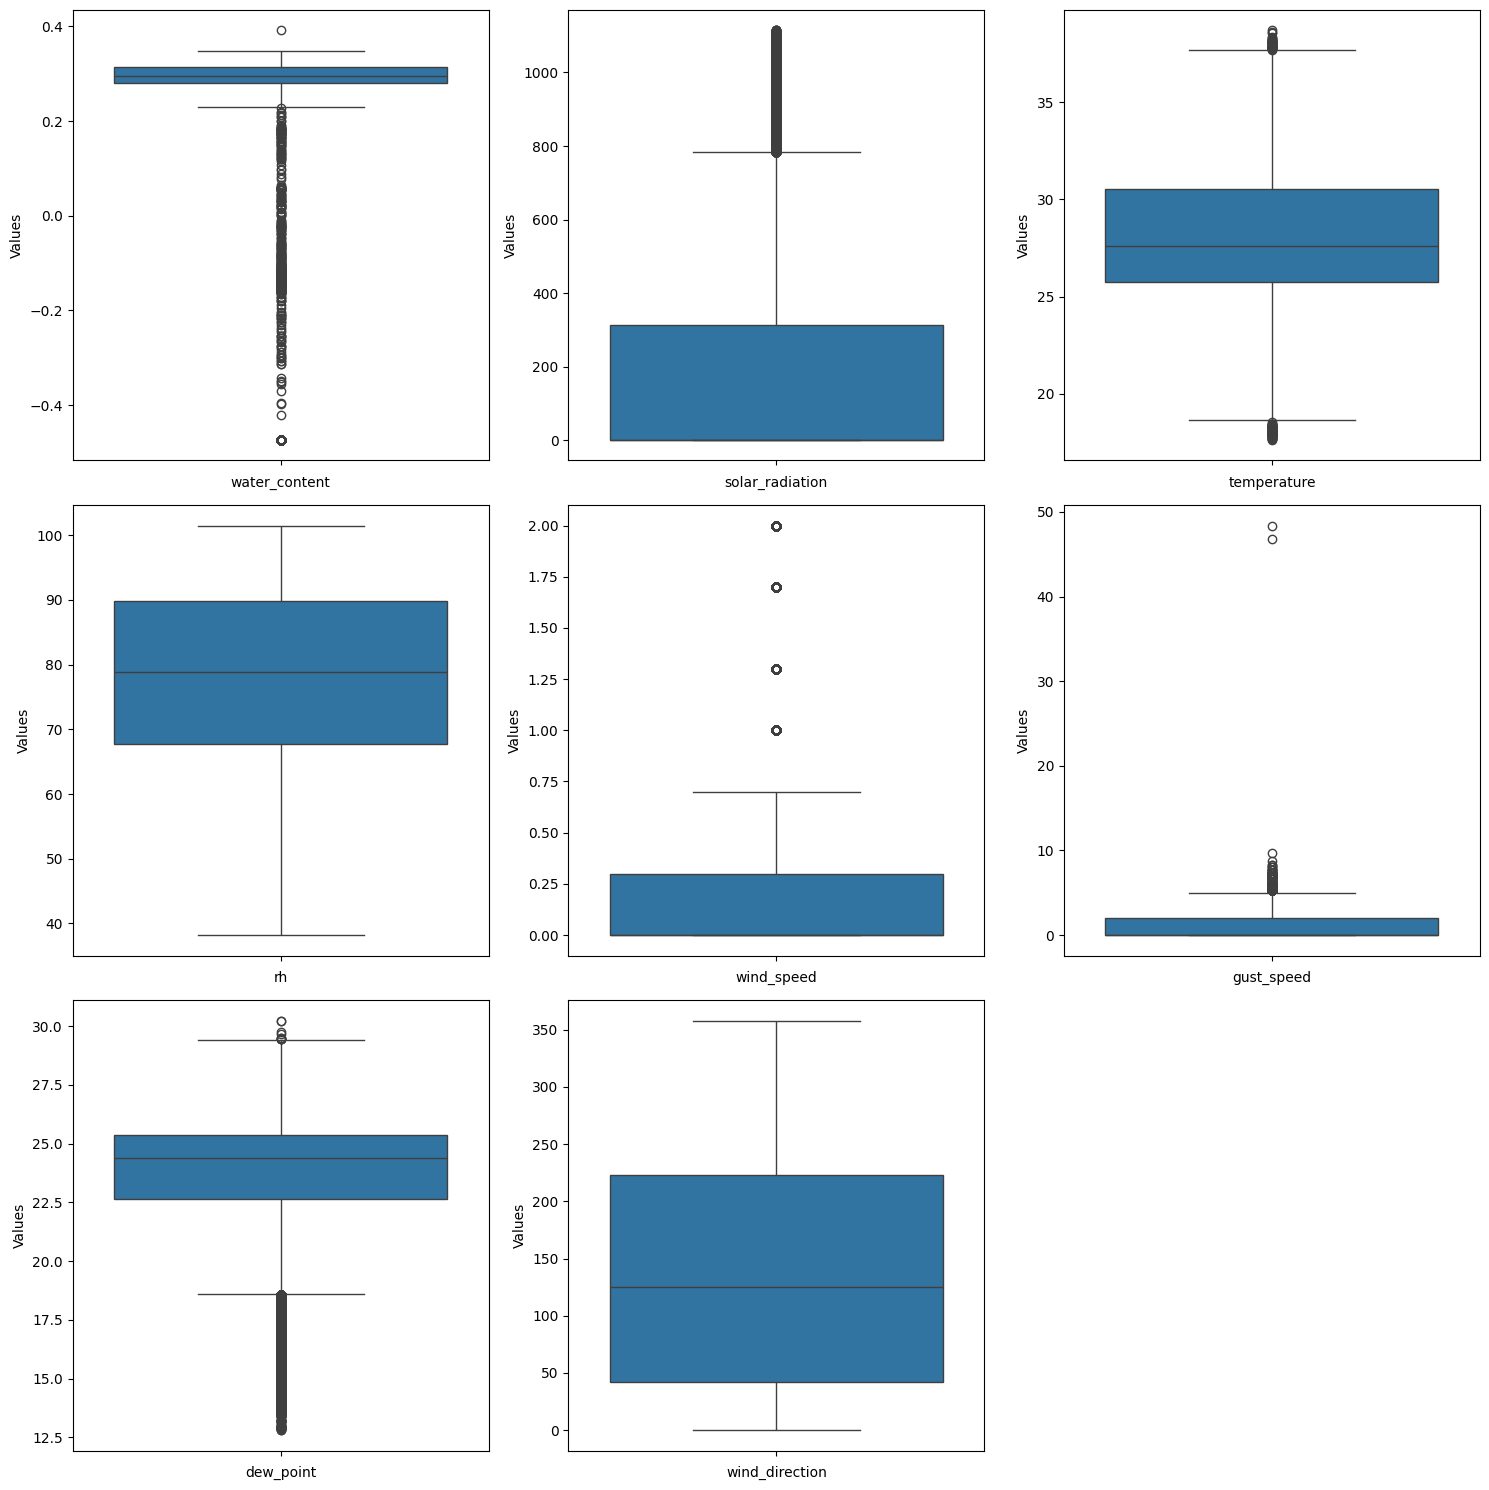

In [40]:
numeric_data = df_cleaned[numeric_columns]

print(len(df_cleaned))

ncols = 3 
nrows = int(np.ceil(len(numeric_columns) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 5))

axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(data=numeric_data[column], ax=axes[i])
    axes[i].set_ylabel("Values")
    axes[i].set_xlabel(column)

for i in range(len(numeric_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [41]:
df_cleaned.head()

,date,time,water_content,solar_radiation,rain,temperature,rh,wind_speed,gust_speed,wind_direction,dew_point
0,2021-04-01,00:00:00,0.2534,1.0,0.0,28.120001,80.599998,0.0,0.3,149.0,24.500000
1,2021-04-01,00:05:00,0.2532,1.0,0.0,28.020000,81.000000,0.0,0.0,215.0,24.490000
2,2021-04-01,00:10:00,0.2524,1.0,0.0,28.070000,81.000000,0.0,1.3,170.0,24.530001
3,2021-04-01,00:15:00,0.2524,1.0,0.0,28.100000,80.800003,0.0,1.7,166.0,24.520000
4,2021-04-01,00:20:00,0.2524,1.0,0.0,28.070000,80.800003,0.3,2.7,181.0,24.490000


##### Write it into hadoop

In [42]:
spark = SparkSession.builder \
    .appName("Save Cleaned DataFrame") \
    .getOrCreate()

# Convert Pandas DataFrame to Spark DataFrame
df_spark = spark.createDataFrame(df_cleaned)

df_spark.write \
    .mode("overwrite") \
    .option("header", "true") \
    .option("compression", "none") \
    .csv(f'{CLEANED_PATH}/cleaned_data.csv')

25/02/01 16:52:14 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
25/02/01 16:52:20 WARN TaskSetManager: Stage 242 contains a task of very large size (1305 KiB). The maximum recommended task size is 1000 KiB.


##### Verify the file write successfully

In [43]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Read CSV from HDFS") \
    .getOrCreate()

# Path to the CSV file on HDFS
file_path = f'{CLEANED_PATH}/cleaned_data.csv'

schema = Constants.WEATHER_DATA_SCHEMA
# Read the CSV file into a DataFrame
df = spark.read.csv(file_path, header=True)

df.show(5)
df.printSchema()
df.count()


25/02/01 16:52:22 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+----------+--------+-------------------+---------------+----+------------------+----------------+-------------------+-------------------+--------------+------------------+
|      date|    time|      water_content|solar_radiation|rain|       temperature|              rh|         wind_speed|         gust_speed|wind_direction|         dew_point|
+----------+--------+-------------------+---------------+----+------------------+----------------+-------------------+-------------------+--------------+------------------+
|2020-10-23|01:15:00| 0.3068999946117401|            1.0| 0.0|25.770000457763672|92.4000015258789|                0.0|0.30000001192092896|         277.0|24.469999313354492|
|2020-10-23|01:20:00|0.30660000443458557|            1.0| 0.0|25.739999771118164|92.4000015258789|                0.0|  0.699999988079071|         320.0|24.450000762939453|
|2020-10-23|01:25:00| 0.3068999946117401|            1.0| 0.0|25.790000915527344|92.0999984741211|0.30000001192092896| 1.29999995231628

154637